# Doppelgänger: A Face Similarity Project

I analyze the face of user(s) and output the most similar face from a database of well-known figures.

In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import tzinfo, timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os.path
from os import path

# Where is the data from?

The data was downloaded from the website of two age and gender detectors called "IMDB-WIKI – 500k+ face images with age and gender labels" (Rasmus Rothe, Radu Timofte, Luc Van Gool - ETH Zürich’s Computer Vision Lab)

The images were webcrawled from the IMDB profiles of celebrities and Wikipedia pages of articles of people by popularity (visits) at some point before February 2016 (when the images were created).


## What does the data look like?

All files are downloadable as .tar archives. There is a wiki_data folder and imdb_data folder that contain subfolders of images and a .mat file of metadata.

The authors used matlab for all of their coding and storage of their text metadata. I converted the metadata to python myself, which is essentially decompressing/flattenting the arrays and dictionaries that appear when the .mat files are read in by scipy. I saved my conversion work as pandas DataFrames in csv format.

You have the ability to download the full images in batches or the cropped images of the faces.
    - Stored in subfolders numbered 0-99
    - File types of the images are .jpg


# Step 1: Load the metadata for both datasets

In [2]:
#Load the dataframes from each dataset
imdb_photo_info = pd.read_csv('Photo_Dataframes/imdb_photo_metadata.csv')
wiki_photo_info = pd.read_csv('Photo_Dataframes/wiki_photo_metadata.csv')

#Concat the dataframes to create one main dataframe
photo_info = pd.concat([imdb_photo_info, wiki_photo_info]).reset_index(drop=True)


In [3]:
#Prior to any data cleanup there are 522,927 photos in the combined dataset
#62,204 come from wikipedia and 460,723 come from imdb
photo_info.head()

,name,dob,gender,photo_taken,file_path,face_location,face_score,second_face_score
0,Fred Astaire,693726,1.0,1968,image_data/imdb_data/01/nm0000001_rm124825600_...,[1072.926 161.838 1214.784 303.696],1.459693,1.118973
1,Fred Astaire,693726,1.0,1970,image_data/imdb_data/01/nm0000001_rm3343756032...,[477.184 100.352 622.592 245.76 ],2.543198,1.852008
2,Fred Astaire,693726,1.0,1968,image_data/imdb_data/01/nm0000001_rm577153792_...,[114.96964309 114.96964309 451.68657236 451.68...,3.455579,2.985660
3,Fred Astaire,693726,1.0,1968,image_data/imdb_data/01/nm0000001_rm946909184_...,[622.88550564 424.21750384 844.33900767 645.67...,1.872117,NaN
4,Fred Astaire,693726,1.0,1968,image_data/imdb_data/01/nm0000001_rm980463616_...,[1013.85900236 233.88204221 1201.5861278 42...,1.158766,NaN


In [4]:
photo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522927 entries, 0 to 522926
Data columns (total 8 columns):
name                 522927 non-null object
dob                  522927 non-null int64
gender               511946 non-null float64
photo_taken          522927 non-null int64
file_path            522927 non-null object
face_location        522927 non-null object
face_score           522927 non-null float64
second_face_score    217885 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 31.9+ MB


## The metadata mainframe information


### Given:
-**name:** Name of the person

-**dob:** date of birth (Matlab serial date number)

-**gender:** 0 for female and 1 for male, NaN if unknown

-**photo_taken:** year when the photo was taken

-**full_path:** path to file

-**face_location:** location of the face. To crop the face in Matlab run img(face_location(2):face_location(4),face_location(1):face_location(3),:))

-**face_score:** detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image

**Not Seen In This Notebook:**

-**second_face_score:** detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.**Not Seen In This Notebook**

-**celeb_names (IMDB only):** list of all celebrity names

-**celeb_id (IMDB only):** index of celebrity name


### Created:

-**age_when_taken** birthdate subtracted from photo_taken

# Step 2: Initial Analysis

(0, 8)

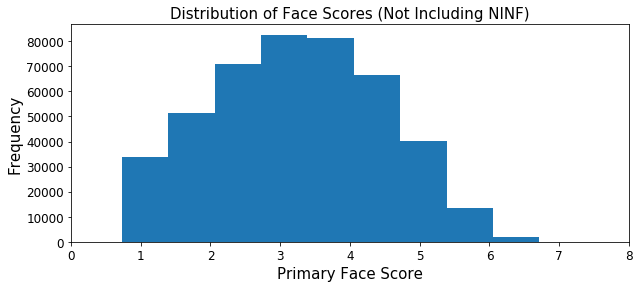

In [5]:
plt.figure(figsize=(10,4))
photo_info['face_score'][photo_info['face_score']>0].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Primary Face Score", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title('Distribution of Face Scores (Not Including NINF)',fontsize=15)
plt.xlim(0, 8)

# Step 3: Convert The Birthdays

In [6]:
#Remove rows where the matlab birthdays will not convert to pandas because of incorrect information
#If the matlab number only contains the year then it won't properly convert (522,798 remaining)
photo_info = photo_info[photo_info['dob'] >= 2000].reset_index(drop=True)

In [7]:
#A function that converts the matlab datetime object to the pandas datetime format 
def convert_matlab_dob(birthday):
    return (datetime.fromordinal(int(birthday)) + timedelta(days=birthday%1) - timedelta(days = 366)).date()

In [8]:
photo_info['dob'] = photo_info['dob'].apply(convert_matlab_dob)

In [9]:
#Creates an "age_when_taken" column (year photo taken - dob)
year_birth_extraction = lambda x: (int(x.year))
photo_info['age_when_taken'] = photo_info.photo_taken - photo_info.dob.map(year_birth_extraction)

In [10]:
photo_info.head()

,name,dob,gender,photo_taken,file_path,face_location,face_score,second_face_score,age_when_taken
0,Fred Astaire,1899-05-10,1.0,1968,image_data/imdb_data/01/nm0000001_rm124825600_...,[1072.926 161.838 1214.784 303.696],1.459693,1.118973,69
1,Fred Astaire,1899-05-10,1.0,1970,image_data/imdb_data/01/nm0000001_rm3343756032...,[477.184 100.352 622.592 245.76 ],2.543198,1.852008,71
2,Fred Astaire,1899-05-10,1.0,1968,image_data/imdb_data/01/nm0000001_rm577153792_...,[114.96964309 114.96964309 451.68657236 451.68...,3.455579,2.985660,69
3,Fred Astaire,1899-05-10,1.0,1968,image_data/imdb_data/01/nm0000001_rm946909184_...,[622.88550564 424.21750384 844.33900767 645.67...,1.872117,NaN,69
4,Fred Astaire,1899-05-10,1.0,1968,image_data/imdb_data/01/nm0000001_rm980463616_...,[1013.85900236 233.88204221 1201.5861278 42...,1.158766,NaN,69


Text(0, 0.5, 'Frequency')

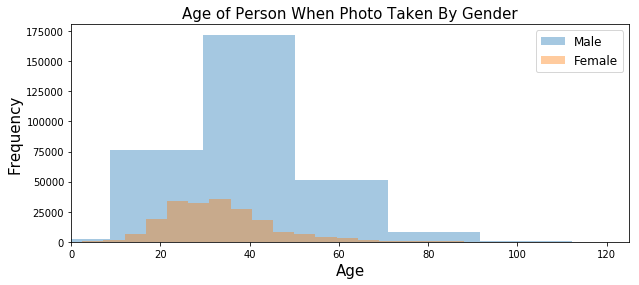

In [11]:
plt.figure(figsize=(10,4))
df = photo_info[photo_info.gender == 1.0]
sns.distplot(df['age_when_taken'], kde=False, bins = 100, label='Male')

df =photo_info[photo_info.gender == 0.0]
sns.distplot(df['age_when_taken'],  kde=False, bins = 100, label='Female')



# Plot formatting
plt.legend(prop={'size': 12})
plt.xlim(0, 125)
plt.title('Age of Person When Photo Taken By Gender', fontsize=15)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

In [12]:
#A check to see the null values in the 'python_dob' column after the birthday conversion
photo_info[['name', 'dob']][photo_info.dob.isnull()].groupby(['name', 'dob']).first()

""


# Step 4: Remove Entries With Incomplete Information

In [13]:
#3,703 entries have omitted genders
len(photo_info[['name', 'gender']][~photo_info['gender'].isin([0,1])].groupby(['name']))

3703

In [14]:
#Remove the photos with omitted genders, 511,817 photos remain
photo_info = photo_info[photo_info['gender'].isin([0,1])].reset_index(drop=True)

In [15]:
#Eliminate all images with a -inf primary face score because that means no face was detected
#434,539 photos remain
photo_info = photo_info[photo_info['face_score'] != np.NINF].reset_index(drop=True)

# Step 5: Face Score And Second Face Score

The face with the highest **face_score** is the default face for a given person.

The three options for dealing with this are:
    
   (1) Manually label each face
        
   (2) Drop all images where multiple faces were detected (298,367 images left)
        
   (3) Create a threshold metric where there is a minimum percent difference between the first face score and the second face score (What the paper suggests)
        
   -Worked for Lauren Bacall but not for Fred Astaire:
            
   -Fred Astaire's Picture His face wasn't detected, most likely because of the obscured eyes
                
   -Lauren Bacall's Pictures Group photos were dropped because the faces had similar scores.

    
This is where the second_face_score comes in handy

In [16]:
#Remove all photos where the primary face score is below 1 as these faces are far away or obscured
#422,775 photos remain
photo_info = photo_info[photo_info['face_score']>1]

In [17]:
#Eliminate all images where the first and second face scores are similar
#This means that there is a high chance that the photo was a group photo and
#the best face is not necessarily the face of the person labeled
#264,534 photos remain

#Originally 0.9, lowered to 0.25

#372,917 remain to 214,617

photo_info['percent_face'] = (photo_info['second_face_score'] / photo_info['face_score'])

photo_info = photo_info[(photo_info['percent_face'] <= 0.25) | (photo_info['percent_face'].isnull())].reset_index(drop=True)

In [18]:
photo_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214617 entries, 0 to 214616
Data columns (total 10 columns):
name                 214617 non-null object
dob                  214617 non-null object
gender               214617 non-null float64
photo_taken          214617 non-null int64
file_path            214617 non-null object
face_location        214617 non-null object
face_score           214617 non-null float64
second_face_score    4432 non-null float64
age_when_taken       214617 non-null int64
percent_face         4432 non-null float64
dtypes: float64(4), int64(2), object(4)
memory usage: 16.4+ MB


In [19]:
#Reorganize the dataframe so that name is the first column after the index
photo_info = photo_info[['name', 'dob', 'gender', 'photo_taken', 'age_when_taken', 'file_path', 'face_location', 'face_score']]

photo_info.reset_index(drop=True)
photo_info.head()

,name,dob,gender,photo_taken,age_when_taken,file_path,face_location,face_score
0,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm946909184_...,[622.88550564 424.21750384 844.33900767 645.67...,1.872117
1,Fred Astaire,1899-05-10,1.0,1968,69,image_data/imdb_data/01/nm0000001_rm980463616_...,[1013.85900236 233.88204221 1201.5861278 42...,1.158766
2,Lauren Bacall,1924-09-16,0.0,2004,80,image_data/imdb_data/02/nm0000002_rm1346607872...,[ 78.23569407 52.33512938 194.25423516 168.35...,3.479189
3,Lauren Bacall,1924-09-16,0.0,2004,80,image_data/imdb_data/02/nm0000002_rm1363385088...,[ 64.30867104 64.30867104 207.26768087 207.26...,3.870171
4,Lauren Bacall,1924-09-16,0.0,1974,50,image_data/imdb_data/02/nm0000002_rm221957120_...,[3173.14469259 401.04083657 4059.15207489 128...,4.096431


In [20]:
#A check to see if the file path exists
file_exists = 0
file_not_exist = 0

for i in photo_info.file_path:
    if path.exists(i):
        file_exists += 1
    else: 
        file_not_exist += 1
        
print(file_exists)
print(file_not_exist)

214617
0


In [21]:
photo_info.to_csv('Photo_Dataframes/All_Photo_Data.csv', index = False)